## Modelación de sistema de prestamos con XGboost

Proyecto realizado para la materia análisis multivariado en el semestre 2022-1, FC, UNAM

4. El archivo *prestamos.csv* contiene un registro histórico de préstamos que ha otorgado una institución financiera durante el último año, en la columna estado del prestamo hay una etiqueta que indica si el crédito se pagó completo o si se ha impagado:

###### a) Se pide limpiar el archivo, imputar valores perdidos si es que es necesario y realizar un analisis descriptivo utilizando las estadísticas y gráficos multivariados para determinar si es posible identificar diferencias significativas entre los impagadores y los no impagadores partiendo de los datos de aplicacion del crédito. Genere nuevas variables a partir de las anteriores si cree que estas pudieran ayudar a explicar mejor la diferencia entre una clase y otra.

##### Conociendo la base de datos

In [362]:
# Primero importamos las librerías y el dataset
import pandas as pd
import numpy as np
data = pd.read_csv('prestamos.csv')
# Vistazo general a la base de datos
display(data.head())
display(data.tail())
display(data.info())
display(data.describe())

,monto_principal,monto_fondeado,fondo_inversion,plazo,tasa_interes,cuota_mensual,calificacion_creditica,sub_calificiacion_creditica,antiguedad_empleo_aplicante,estaus_vivienda,ingreso_anual,estado_credito
0,5000,5000,4975.0,36,10.65%,162.87,B,B2,10+,Renta,24000.0,pagado
1,2500,2500,2500.0,60,15.27%,59.83,C,C4,< 1,Renta,30000.0,impago
2,2400,2400,2400.0,36,15.96%,84.33,C,C5,10+,Renta,12252.0,pagado
3,10000,10000,10000.0,36,13.49%,339.31,C,C1,10+,Renta,49200.0,pagado
4,5000,5000,5000.0,36,7.90%,156.46,A,A4,3,Renta,36000.0,pagado


,monto_principal,monto_fondeado,fondo_inversion,plazo,tasa_interes,cuota_mensual,calificacion_creditica,sub_calificiacion_creditica,antiguedad_empleo_aplicante,estaus_vivienda,ingreso_anual,estado_credito
38572,2500,2500,1075.0,36,8.07%,78.42,A,A4,4,Hipoteca,110000.0,pagado
38573,8500,8500,875.0,36,10.28%,275.38,C,C1,3,Renta,18000.0,pagado
38574,5000,5000,1325.0,36,8.07%,156.84,A,A4,< 1,Hipoteca,100000.0,pagado
38575,5000,5000,650.0,36,7.43%,155.38,A,A2,< 1,Hipoteca,200000.0,pagado
38576,7500,7500,800.0,36,13.75%,255.43,E,E2,< 1,Propia,22000.0,pagado


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38577 entries, 0 to 38576
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   monto_principal              38577 non-null  int64  
 1   monto_fondeado               38577 non-null  int64  
 2   fondo_inversion              38577 non-null  float64
 3   plazo                        38577 non-null  int64  
 4   tasa_interes                 38577 non-null  object 
 5   cuota_mensual                38577 non-null  float64
 6   calificacion_creditica       38577 non-null  object 
 7   sub_calificiacion_creditica  38577 non-null  object 
 8   antiguedad_empleo_aplicante  37544 non-null  object 
 9   estaus_vivienda              38577 non-null  object 
 10  ingreso_anual                38577 non-null  float64
 11  estado_credito               38577 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 3.5+ MB


None

,monto_principal,monto_fondeado,fondo_inversion,plazo,cuota_mensual,ingreso_anual
count,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,3.857700e+04
mean,11047.025430,10784.058506,10222.481123,41.898437,322.466318,6.877797e+04
std,7348.441646,7090.306027,7022.720644,10.333136,208.639215,6.421868e+04
min,500.000000,500.000000,0.000000,36.000000,15.690000,4.000000e+03
25%,5300.000000,5200.000000,5000.000000,36.000000,165.740000,4.000000e+04
50%,9600.000000,9550.000000,8733.440000,36.000000,277.860000,5.886800e+04
75%,15000.000000,15000.000000,14000.000000,36.000000,425.550000,8.200000e+04
max,35000.000000,35000.000000,35000.000000,60.000000,1305.190000,6.000000e+06


Nos damos cuenta que:
1. Tenemos 12 variables siendo estado_credito el target, 38577 usuarios cada uno con su respectiva información financiera y bancaria.
2. la variable *tasa_interes* debe ser convertida a tipo flotante
3. las variables de tipo object *calificación_crediticia*,*sub_calificación_crediticia*,*antiguedad_empleo_aplicante*,*	estaus_vivienda* y *estado_credito* pueden ser tranformadas a entero con ayuda de un diccionario.
4. La variable monto_principal y monto_fondeado parecen ser idénticas
5. La variable plazo es en realidad categórica

Verifiquemos si existen missing values


##### limpiando tasa_interes

In [363]:
data['tasa_interes'] = data['tasa_interes'].str.strip('%')
data['tasa_interes'] = data['tasa_interes'].astype('float64')
print(data['tasa_interes'])

0        10.65
1        15.27
2        15.96
3        13.49
4         7.90
         ...  
38572     8.07
38573    10.28
38574     8.07
38575     7.43
38576    13.75
Name: tasa_interes, Length: 38577, dtype: float64


##### Missing values

In [364]:
# La siguiente función cuenta los missing values por columna
def count_missing_values(dataset_df):
    dataset_df = dataset_df.copy()
    total_df = pd.DataFrame(dataset_df.isnull().sum().sort_values(ascending=True),columns=['missings'])
    return total_df
    
missings_df = count_missing_values(data)
missings_df

,missings
monto_principal,0
monto_fondeado,0
fondo_inversion,0
plazo,0
tasa_interes,0
cuota_mensual,0
calificacion_creditica,0
sub_calificiacion_creditica,0
estaus_vivienda,0
ingreso_anual,0


La única variable que posee missing values es *antiguedad_empleo_aplicante* con 1033. Se procederá a imputar

In [365]:
from sklearn.impute import SimpleImputer
imputador_antiguedad = SimpleImputer(strategy='most_frequent') #se usa la estrategia de la moda (asigna la moda de la columna a cada valor perdido)
data['antiguedad_empleo_aplicante'] = pd.DataFrame(imputador_antiguedad.fit_transform(np.array(data['antiguedad_empleo_aplicante']).reshape(-1,1)))

Ya podemos verificar que en efecto no hay missing values

In [366]:
missings_df = count_missing_values(data)
missings_df #Notemos que ya no hay missings

,missings
monto_principal,0
monto_fondeado,0
fondo_inversion,0
plazo,0
tasa_interes,0
cuota_mensual,0
calificacion_creditica,0
sub_calificiacion_creditica,0
antiguedad_empleo_aplicante,0
estaus_vivienda,0


##### Análisis de variables categóricas

In [367]:
cathegorical_cols = ["plazo","calificacion_creditica","sub_calificiacion_creditica","antiguedad_empleo_aplicante","estaus_vivienda","estado_credito"]

for col in cathegorical_cols:
    display(data.groupby(col)[[col]].count())

,plazo
plazo,
36,29096
60,9481


,calificacion_creditica
calificacion_creditica,
A,10045
B,11675
C,7834
D,5085
E,2663
F,976
G,299


,sub_calificiacion_creditica
sub_calificiacion_creditica,
A1,1139
A2,1508
A3,1810
A4,2873
A5,2715
B1,1797
B2,2001
B3,2825
B4,2437


,antiguedad_empleo_aplicante
antiguedad_empleo_aplicante,
1,3169
10+,9521
2,4291
3,4012
4,3342
5,3194
6,2168
7,1711
8,1435


,estaus_vivienda
estaus_vivienda,
Hipoteca,17021
No se sabe,3
Otro,98
Propia,2975
Renta,18480


,estado_credito
estado_credito,
impago,5627
pagado,32950


Para propósitos generales se puede usar la información arriba descrita, a partir de estas también se podrían general graficas de tipo pastel o histogramas.

Ahora corroboramos si en verdad la variable *monto_principal* y *monto_fondeado* son iguales

In [368]:
(data['monto_principal'] == data['monto_fondeado']).count()

38577

Coinciden, pues en total ya teníamos 38577 columnas. Decidimos extraer la varible monto fondeado
Nota. Se recomienda revisar esto de nuevo en caso de tener datos nuevos, pues pudo ser una coincidencia.

In [369]:
data = data.drop("monto_fondeado", axis=1)
data.head()

,monto_principal,fondo_inversion,plazo,tasa_interes,cuota_mensual,calificacion_creditica,sub_calificiacion_creditica,antiguedad_empleo_aplicante,estaus_vivienda,ingreso_anual,estado_credito
0,5000,4975.0,36,10.65,162.87,B,B2,10+,Renta,24000.0,pagado
1,2500,2500.0,60,15.27,59.83,C,C4,< 1,Renta,30000.0,impago
2,2400,2400.0,36,15.96,84.33,C,C5,10+,Renta,12252.0,pagado
3,10000,10000.0,36,13.49,339.31,C,C1,10+,Renta,49200.0,pagado
4,5000,5000.0,36,7.90,156.46,A,A4,3,Renta,36000.0,pagado


Se decide incluir la categoría "No se sabe" en "Otro" en la variable estaus_vivienda, pues esta tan solo contiene 3 observaciones en contraste con los demás estatus parece insignificante, además simplifca el análisis.

data.loc[data['estaus_vivienda'] == 'No se sabe', 'estaus_vivienda'] = 'Otro'
for col in cathegorical_cols:
    display(data.groupby(col)[[col]].count())

In [370]:
data['plazo'] = data.plazo.astype(str)

Ahora procederemos a asignar un diccionario de variables para las variables categóricas

In [371]:
def compute_frequencies(dataset_df,col,index=None):
    if index is None:
        index = 'index'
    columns=[col,'freqs_'+col,'relative_freqs_'+col]
    freqs_df = dataset_df.reset_index()\
                .groupby(col)\
                .count()\
                .reset_index()[[index,col]]\
                .rename(columns={index:'freqs_'+col})
    
    freqs_df['relative_freqs_'+col] = freqs_df['freqs_'+col]/len(data)
    freqs_df= freqs_df[columns].sort_values(col)
    missings_counts = data[col].isna().sum()
    missings_df = pd.DataFrame([['Missings',missings_counts,missings_counts/len(data)]],columns=columns)
    freqs_df = pd.concat([freqs_df, missings_df])
    return freqs_df

In [372]:
categorical_cols = ["plazo","calificacion_creditica","sub_calificiacion_creditica","antiguedad_empleo_aplicante","estaus_vivienda","estado_credito"]
map_dictionary = {}
for col in categorical_cols:
    freqs_df = compute_frequencies(data,col) #
    display(freqs_df) #
    colum_values = list(freqs_df[col])[:len(freqs_df)-1] #
    column_dict = {} 
    for i,value in enumerate(colum_values):
        column_dict.update({value:str(int(i))})
    column_dict.update({np.nan:np.nan})
    map_dictionary.update({col:column_dict})
data_clean = data.replace(map_dictionary).copy()

,plazo,freqs_plazo,relative_freqs_plazo
0,36,29096,0.754232
1,60,9481,0.245768
0,Missings,0,0.000000


,calificacion_creditica,freqs_calificacion_creditica,relative_freqs_calificacion_creditica
0,A,10045,0.260388
1,B,11675,0.302641
2,C,7834,0.203074
3,D,5085,0.131814
4,E,2663,0.069031
5,F,976,0.025300
6,G,299,0.007751
0,Missings,0,0.000000


,sub_calificiacion_creditica,freqs_sub_calificiacion_creditica,relative_freqs_sub_calificiacion_creditica
0,A1,1139,0.029525
1,A2,1508,0.039091
2,A3,1810,0.046919
3,A4,2873,0.074474
4,A5,2715,0.070379
5,B1,1797,0.046582
6,B2,2001,0.051870
7,B3,2825,0.073230
8,B4,2437,0.063172
9,B5,2615,0.067787


,antiguedad_empleo_aplicante,freqs_antiguedad_empleo_aplicante,relative_freqs_antiguedad_empleo_aplicante
0,1,3169,0.082147
1,10+,9521,0.246805
2,2,4291,0.111232
3,3,4012,0.104000
4,4,3342,0.086632
5,5,3194,0.082795
6,6,2168,0.056199
7,7,1711,0.044353
8,8,1435,0.037198
9,9,1226,0.031781


,estaus_vivienda,freqs_estaus_vivienda,relative_freqs_estaus_vivienda
0,Hipoteca,17021,0.441221
1,No se sabe,3,0.000078
2,Otro,98,0.002540
3,Propia,2975,0.077118
4,Renta,18480,0.479042
0,Missings,0,0.000000


,estado_credito,freqs_estado_credito,relative_freqs_estado_credito
0,impago,5627,0.145864
1,pagado,32950,0.854136
0,Missings,0,0.000000


Entonces la base ya limpia es la siguiente

In [373]:
data_clean

,monto_principal,fondo_inversion,plazo,tasa_interes,cuota_mensual,calificacion_creditica,sub_calificiacion_creditica,antiguedad_empleo_aplicante,estaus_vivienda,ingreso_anual,estado_credito
0,5000,4975.0,0,10.65,162.87,1,6,1,4,24000.0,1
1,2500,2500.0,1,15.27,59.83,2,13,10,4,30000.0,0
2,2400,2400.0,0,15.96,84.33,2,14,1,4,12252.0,1
3,10000,10000.0,0,13.49,339.31,2,10,1,4,49200.0,1
4,5000,5000.0,0,7.90,156.46,0,3,3,4,36000.0,1
...,...,...,...,...,...,...,...,...,...,...,...
38572,2500,1075.0,0,8.07,78.42,0,3,4,0,110000.0,1
38573,8500,875.0,0,10.28,275.38,2,10,3,4,18000.0,1
38574,5000,1325.0,0,8.07,156.84,0,3,10,0,100000.0,1
38575,5000,650.0,0,7.43,155.38,0,1,10,0,200000.0,1


##### Estadisticas multivariadas

In [374]:
import seaborn as sns
sns.pairplot(data=data_clean,hue='estado_credito')

A simple vista no podemos afirmar o negar algo desde el pairplot, pues se cree que la escala de los datos afecta la visualización de los mismo, se procederá a la segunda parte del ejercicio

###### b) Basado en el análisis realizado en la tarea anterior, separe el dataset en train y test (70% y 30%), siéntase libre  de decidir si debe imputar, escalar, transformaciones, aplicar reduccion de dimensión a las variables del dataset, recuerde no incluir el target dentro de su ingeniería de variables.

Procedemos a hacer el train split de manera que los datos de entrenamiento tengan el 70% del total. Para facilitar los merges entre variables categoricas y numericas se le pone un nombre al index.

In [375]:
data_clean.index.name = 'index'
data_clean.head()

,monto_principal,fondo_inversion,plazo,tasa_interes,cuota_mensual,calificacion_creditica,sub_calificiacion_creditica,antiguedad_empleo_aplicante,estaus_vivienda,ingreso_anual,estado_credito
index,,,,,,,,,,,
0,5000,4975.0,0,10.65,162.87,1,6,1,4,24000.0,1
1,2500,2500.0,1,15.27,59.83,2,13,10,4,30000.0,0
2,2400,2400.0,0,15.96,84.33,2,14,1,4,12252.0,1
3,10000,10000.0,0,13.49,339.31,2,10,1,4,49200.0,1
4,5000,5000.0,0,7.90,156.46,0,3,3,4,36000.0,1


Notemos que tenemos la mejor versión posible del dataset, podemos aplicar ingenieria de variables. Por ejemplo qué porcentaje del prestamo representa el ingreso del cliente.

In [525]:
#Conjunto de datos y entrenamiento
data_copy = data_clean
from sklearn.model_selection import train_test_split
data_train_df, data_test_df = train_test_split(data_copy, test_size=0.3, random_state=14)
data_train_df

,monto_principal,fondo_inversion,plazo,tasa_interes,cuota_mensual,calificacion_creditica,sub_calificiacion_creditica,antiguedad_empleo_aplicante,estaus_vivienda,ingreso_anual,estado_credito,ganancia
index,,,,,,,,,,,,
10286,2000,2000.000000,0,16.89,71.20,3,18,1,4,40800.0,1,0
31267,3600,3500.000000,0,7.14,111.39,0,2,6,0,62000.0,1,0
28395,3000,3000.000000,0,6.76,92.31,0,1,0,0,74000.0,1,0
8889,8700,8700.000000,0,12.99,293.10,2,10,6,0,102000.0,1,0
1045,14400,14400.000000,0,6.62,442.14,0,1,4,4,50000.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13034,7600,7575.000000,0,12.99,256.04,2,10,7,0,64197.0,1,0
23910,16800,16800.000000,1,16.45,412.58,4,20,1,4,57000.0,1,0
22855,12000,9048.735605,0,5.79,274.46,0,1,3,4,85000.0,1,0


Ahora aplicamos un OneHotEncoder, que se encarga de asignar una columna para cada valor de cada variable categórica, en este caso no incluimos *estado_credito* en este encoder.

In [526]:
categorical_cols = ["plazo","calificacion_creditica","sub_calificiacion_creditica","antiguedad_empleo_aplicante","estaus_vivienda"]#
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False).fit(data_train_df[categorical_cols])
dummy_matrix_train_df = pd.DataFrame(one_hot_encoder.transform(data_train_df[categorical_cols]),
                                      columns=list(one_hot_encoder.get_feature_names(categorical_cols)))
dummy_columns = list(one_hot_encoder.get_feature_names(categorical_cols))
dummy_matrix_train_df['index'] = data_train_df.index
dummy_matrix_train_df.set_index('index',inplace=True)
dummy_matrix_train_df

,plazo_0,plazo_1,calificacion_creditica_0,calificacion_creditica_1,calificacion_creditica_2,calificacion_creditica_3,calificacion_creditica_4,calificacion_creditica_5,calificacion_creditica_6,sub_calificiacion_creditica_0,...,antiguedad_empleo_aplicante_5,antiguedad_empleo_aplicante_6,antiguedad_empleo_aplicante_7,antiguedad_empleo_aplicante_8,antiguedad_empleo_aplicante_9,estaus_vivienda_0,estaus_vivienda_1,estaus_vivienda_2,estaus_vivienda_3,estaus_vivienda_4
index,,,,,,,,,,,,,,,,,,,,,
10286,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31267,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28395,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8889,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1045,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13034,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23910,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22855,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Para las variables numericas o continuas haremos una estandarización y además componentes principales.

In [527]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
numerical_cols = ['monto_principal','fondo_inversion','tasa_interes','cuota_mensual','ingreso_anual']

standard_scaler = StandardScaler().fit(data_train_df[numerical_cols])
std_data_matrix_train = standard_scaler.transform(data_train_df[numerical_cols])
std_data_matrix_train
std_data_matrix_train = pd.DataFrame(std_data_matrix_train, columns = numerical_cols)
std_data_matrix_train = std_data_matrix_train.set_index(data_train_df.index)
std_data_matrix_train

,monto_principal,fondo_inversion,tasa_interes,cuota_mensual,ingreso_anual
index,,,,,
10286,-1.233599,-1.173133,1.347188,-1.206609,-0.502698
31267,-1.014732,-0.958090,-1.293962,-1.013027,-0.115945
28395,-1.096807,-1.029771,-1.396899,-1.104929,0.102971
8889,-0.317092,-0.212608,0.290728,-0.137789,0.613776
1045,0.462623,0.604554,-1.434824,0.580089,-0.334862
...,...,...,...,...,...
13034,-0.467563,-0.373890,0.290728,-0.316295,-0.075865
23910,0.790924,0.948623,1.227998,0.437708,-0.207161
22855,0.134322,-0.162613,-1.659660,-0.227571,0.303644


Finalmente aplicaremos el modelo en el siguiente DataFrame.

In [528]:
categorical = ["plazo","calificacion_creditica","sub_calificiacion_creditica","antiguedad_empleo_aplicante"]
design_matrix_train_df = dummy_matrix_train_df.merge(std_data_matrix_train,left_index=True, right_index=True)
design_matrix_train_df

,plazo_0,plazo_1,calificacion_creditica_0,calificacion_creditica_1,calificacion_creditica_2,calificacion_creditica_3,calificacion_creditica_4,calificacion_creditica_5,calificacion_creditica_6,sub_calificiacion_creditica_0,...,estaus_vivienda_0,estaus_vivienda_1,estaus_vivienda_2,estaus_vivienda_3,estaus_vivienda_4,monto_principal,fondo_inversion,tasa_interes,cuota_mensual,ingreso_anual
index,,,,,,,,,,,,,,,,,,,,,
10286,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-1.233599,-1.173133,1.347188,-1.206609,-0.502698
31267,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-1.014732,-0.958090,-1.293962,-1.013027,-0.115945
28395,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-1.096807,-1.029771,-1.396899,-1.104929,0.102971
8889,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-0.317092,-0.212608,0.290728,-0.137789,0.613776
1045,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.462623,0.604554,-1.434824,0.580089,-0.334862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13034,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-0.467563,-0.373890,0.290728,-0.316295,-0.075865
23910,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.790924,0.948623,1.227998,0.437708,-0.207161
22855,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.134322,-0.162613,-1.659660,-0.227571,0.303644


##### c)Ajustar un modelo de clasificación sobre el dataset de entrenamiento. Siéntase libre de escoger el algoritmo a utilizar. Calcular y graficar la curva ROC, el AUC y el índice de GINI con base a los scores generados por el algoritmo sobre el dataset de test. El AUC obtenido debe ser mayor o igual a 0.70 si no lo alcanza la metrica regresar a los pasos anteriores haciendo ajustes a la ingeniería de variables y al algoritmo de clasificación y repetir hasta alcanzar la métrica mínima.

Se decide usar el modelo clasificador arboles de decicisión en la librería xgboost.

In [529]:
from xgboost import XGBClassifier
target_train_df = data_train_df[['estado_credito']].copy()

dtree_clf = XGBClassifier(
                n_estimators=23,
                max_depth=5,
                learning_rate=0.08,
                gamma=1,
                subsample=0.5,
                scale_pos_weight=0.5,
                random_state=75) #Objeto de la instancia

dtree_clf.fit(design_matrix_train_df,target_train_df[['estado_credito']]) #Se ajusta para obtener los scores

target_train_df['score'] = dtree_clf.predict_proba(design_matrix_train_df)[:,1] 
target_train_df

C:\Users\saya1\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\saya1\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:04:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,estado_credito,score
index,,
10286,1,0.582589
31267,1,0.859793
28395,1,0.863060
8889,1,0.791454
1045,1,0.824271
...,...,...
13034,1,0.765045
23910,1,0.492739
22855,1,0.887457


Como son los datos de entrenamiento se obtienen probas muy altas, procederemos a hacer las mismas transformaciones que hicimos en los datos de entrenamiento en los datos de testeo.

In [530]:
dummy_matrix_test_df = pd.DataFrame(one_hot_encoder.transform(data_test_df[categorical_cols]),
                                     columns=list(one_hot_encoder.get_feature_names(categorical_cols))) 
dummy_matrix_test_df['index'] = data_test_df.index 
dummy_matrix_test_df.set_index('index',inplace=True) 
#one hot en las categoricas del test_df

std_data_matrix_test = standard_scaler.transform(data_test_df[numerical_cols]) #estandariza las numericas
std_data_matrix_test = pd.DataFrame(std_data_matrix_test, columns = numerical_cols)
std_data_matrix_test = std_data_matrix_test.set_index(data_test_df.index)
std_data_matrix_test

,monto_principal,fondo_inversion,tasa_interes,cuota_mensual,ingreso_anual
index,,,,,
29154,0.407906,0.365932,1.328226,0.848522,0.526209
32460,-1.165203,-1.112204,0.824376,-1.132336,-0.499049
26427,-0.618035,-0.528004,-1.193734,-0.575480,-0.544657
16168,0.134322,0.260486,-1.153101,-0.386955,-0.334862
14402,0.407906,0.511369,0.426171,0.001750,-0.363248
...,...,...,...,...,...
7645,3.280539,1.991581,-0.251047,1.002608,0.121214
21936,0.134322,0.253318,0.789160,-0.179646,1.033366
17660,3.280539,3.537536,0.710603,4.256561,1.398226


Juntamos todo

In [531]:
design_matrix_test_df = dummy_matrix_test_df.merge(std_data_matrix_test,left_index=True, right_index=True)#juntamos todo
design_matrix_test_df

,plazo_0,plazo_1,calificacion_creditica_0,calificacion_creditica_1,calificacion_creditica_2,calificacion_creditica_3,calificacion_creditica_4,calificacion_creditica_5,calificacion_creditica_6,sub_calificiacion_creditica_0,...,estaus_vivienda_0,estaus_vivienda_1,estaus_vivienda_2,estaus_vivienda_3,estaus_vivienda_4,monto_principal,fondo_inversion,tasa_interes,cuota_mensual,ingreso_anual
index,,,,,,,,,,,,,,,,,,,,,
29154,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.407906,0.365932,1.328226,0.848522,0.526209
32460,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.165203,-1.112204,0.824376,-1.132336,-0.499049
26427,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-0.618035,-0.528004,-1.193734,-0.575480,-0.544657
16168,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.134322,0.260486,-1.153101,-0.386955,-0.334862
14402,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.407906,0.511369,0.426171,0.001750,-0.363248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7645,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,3.280539,1.991581,-0.251047,1.002608,0.121214
21936,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.134322,0.253318,0.789160,-0.179646,1.033366
17660,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,3.280539,3.537536,0.710603,4.256561,1.398226


In [532]:
target_test_df = data_test_df[['estado_credito']].copy() #copiamos el target
target_test_df['score'] = dtree_clf.predict_proba(design_matrix_test_df)[:,1] #calculamos el score
target_test_df

,estado_credito,score
index,,
29154,0,0.723548
32460,1,0.608178
26427,1,0.781896
16168,0,0.800004
14402,1,0.602098
...,...,...
7645,1,0.710563
21936,1,0.623564
17660,1,0.724451


Convertimos la variable target que en este caso es si el préstamo fue o no pagado a tipo entero

In [533]:
target_train_df['estado_credito'] = target_train_df['estado_credito'].astype(int)
target_test_df['estado_credito'] = target_test_df['estado_credito'].astype(int)

Finalmente calculamos la curva ROC y AUC junto con el índice GINI

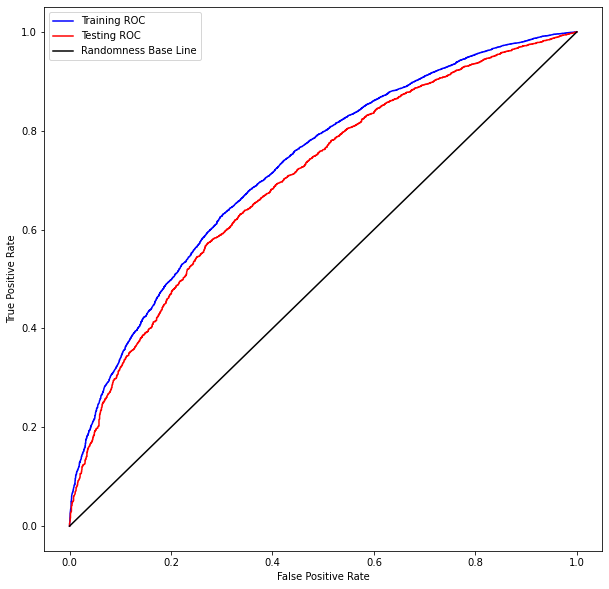

AUC TRAIN: 0.7245677492394952
AUC TEST: 0.7005840124046647
GINI TRAIN: 0.44913549847899037
GINI TEST: 0.40116802480932945


In [534]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_fpr, train_tpr, train_thresholds  = roc_curve(target_train_df['estado_credito'],target_train_df['score'])
test_fpr, test_tpr, test_thresholds  = roc_curve(target_test_df['estado_credito'],target_test_df['score'])

plt.figure(figsize=(10,10))
plt.plot(train_fpr,train_tpr, linestyle='-', color='blue', label='Training ROC')
plt.plot(test_fpr,test_tpr, linestyle='-', color='red', label='Testing ROC')
plt.plot([0,1],[0,1], color='black', label='Randomness Base Line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print('AUC TRAIN:',roc_auc_score(target_train_df['estado_credito'],target_train_df['score']))
print('AUC TEST:',roc_auc_score(target_test_df['estado_credito'],target_test_df['score']))
print('GINI TRAIN:',2*roc_auc_score(target_train_df['estado_credito'],target_train_df['score'])-1)
print('GINI TEST:',2*roc_auc_score(target_test_df['estado_credito'],target_test_df['score'])-1)

Logramos un AUC de .7005, se considera entonces un "buen" modelo.

##### d) Se define la ganancia de la siguiente manera: si el target es 0 entonces la ganancia sera la diferencia entre el monto prestado con interés y el monto prestado, si el target es un 1 entonces la ganancia sera negativa con severidad igual al monto prestado. Con eso calcule y grafique la curva de rentabilidad, encuentre elpunto optimo de maxima ganancia para encontrar el threshold, finalmente uselo para calcular la matriz de confusion, Presicion, Recall, Odds Ratio, F-Score con beta=1, margen de ganancia, denegaciones y admisiones.

Ahora para graficar la curva de rentabilidad será necesario ordenar las probabilidades y obtener la ganancia acumulada.

In [535]:
#Agregamos las variables de prestamo y tasa de interés al target test df
target_test_df['monto_principal'] = design_matrix_test_df['monto_principal']
target_test_df['tasa_interes'] = design_matrix_test_df['tasa_interes']

In [536]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#Definimos ganancia
target_test_df.sort_values('score',ascending=False,inplace=True)
target_test_df['ganancia'] = np.where(target_test_df['estado_credito']==0,target_test_df['monto_principal']/100 + 1,-target_test_df['monto_principal'])
target_test_df['ganancia_acumulada'] = target_test_df['ganancia'].cumsum()

threshold_row = target_test_df[target_test_df['ganancia_acumulada'] == target_test_df['ganancia_acumulada'].max()]
threshold_cutoff = threshold_row['score'].values[0]
target_test_df['estado_credito_est'] = np.where(target_test_df['score']>=threshold_cutoff,1,0)

precision = precision_score(target_test_df['estado_credito'],target_test_df['estado_credito_est'])
recall = recall_score(target_test_df['estado_credito'],target_test_df['estado_credito_est'])
f1 = f1_score(target_test_df['estado_credito'],target_test_df['estado_credito_est'])
accuracy = accuracy_score(target_test_df['estado_credito'],target_test_df['estado_credito_est'])

HEAD:


,estado_credito,score,monto_principal,tasa_interes,ganancia,ganancia_acumulada,estado_credito_est
index,,,,,,,
8922,1,0.893981,-0.139262,-1.759888,0.139262,0.139262,1
6696,1,0.893981,-0.139262,-1.434824,0.139262,0.278525,1
9430,1,0.893981,0.681490,-1.605483,-0.681490,-0.402965,1
20040,1,0.893981,0.681490,-1.456495,-0.681490,-1.084455,1
6154,1,0.893981,0.407906,-1.434824,-0.407906,-1.492361,1


TAIL:


,estado_credito,score,monto_principal,tasa_interes,ganancia,ganancia_acumulada,estado_credito_est
index,,,,,,,
14192,1,0.323893,-0.053767,2.558054,0.053767,1766.613770,0
10905,0,0.312342,1.912618,2.660991,1.019126,1767.632896,0
15362,1,0.305953,-0.864260,2.620358,0.864260,1768.497157,0
12490,1,0.304301,-1.028411,2.590560,1.028411,1769.525568,0
9998,0,0.298482,0.425005,2.761219,1.004250,1770.529818,0


OPTIMAL THRESHOLD CUTOFF SCORE VALUE:


,estado_credito,score,monto_principal,tasa_interes,ganancia,ganancia_acumulada
index,,,,,,
11075,0,0.594716,0.134322,0.019841,1.001343,1818.427929


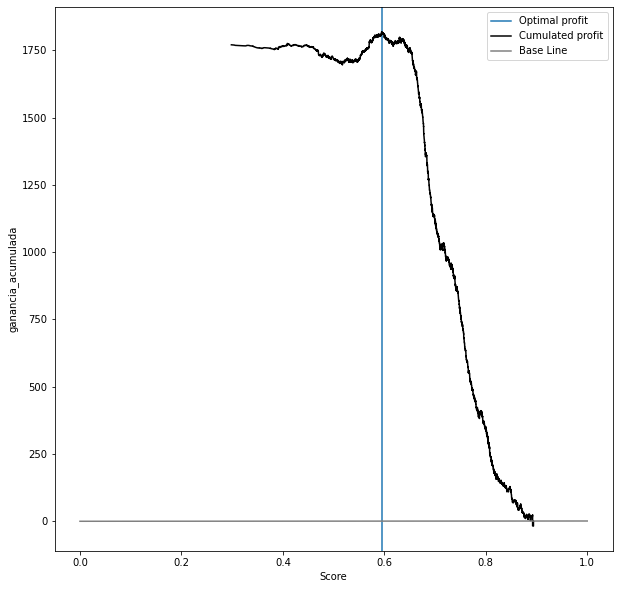

PRECISION: 0.8875075803517283
RECALL: 0.883756038647343
F1: 0.8856278366111952
ACURACY: 0.8040435458786936
DENIED OPERATIONS: 9894
DENIED PERCENTAGE: 0.8548470710212546


In [537]:
print('HEAD:')
display(target_test_df.head(5))
print('TAIL:')
display(target_test_df.tail(5))
print('OPTIMAL THRESHOLD CUTOFF SCORE VALUE:')
display(threshold_row)

plt.figure(figsize=(10,10))
plt.axvline(x=threshold_cutoff,label='Optimal profit')
plt.plot(target_test_df['score'].values,target_test_df['ganancia_acumulada'].values, linestyle='-', color='Black', label='Cumulated profit')
plt.plot([1,0],[1,0], linestyle='-', color='Gray', label='Base Line')

plt.xlabel('Score')
plt.ylabel('ganancia_acumulada')
plt.legend()
plt.show()

print('PRECISION:',precision)
print('RECALL:',recall)
print('F1:',f1)
print('ACURACY:',accuracy)
print('DENIED OPERATIONS:',len(target_test_df[target_test_df['score']>=threshold_cutoff]))
print('DENIED PERCENTAGE:',len(target_test_df[target_test_df['score']>=threshold_cutoff])/len(target_test_df))

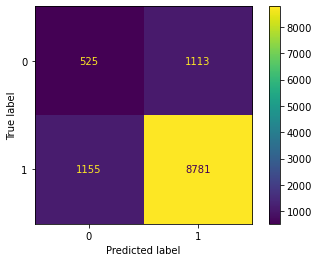

In [538]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(target_test_df['estado_credito'],target_test_df['estado_credito_est'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


Con la matriz de confusión podemos ver qué cantidad de datos clasificó bien el modelo